## Quantidade de amostras separados por classe:

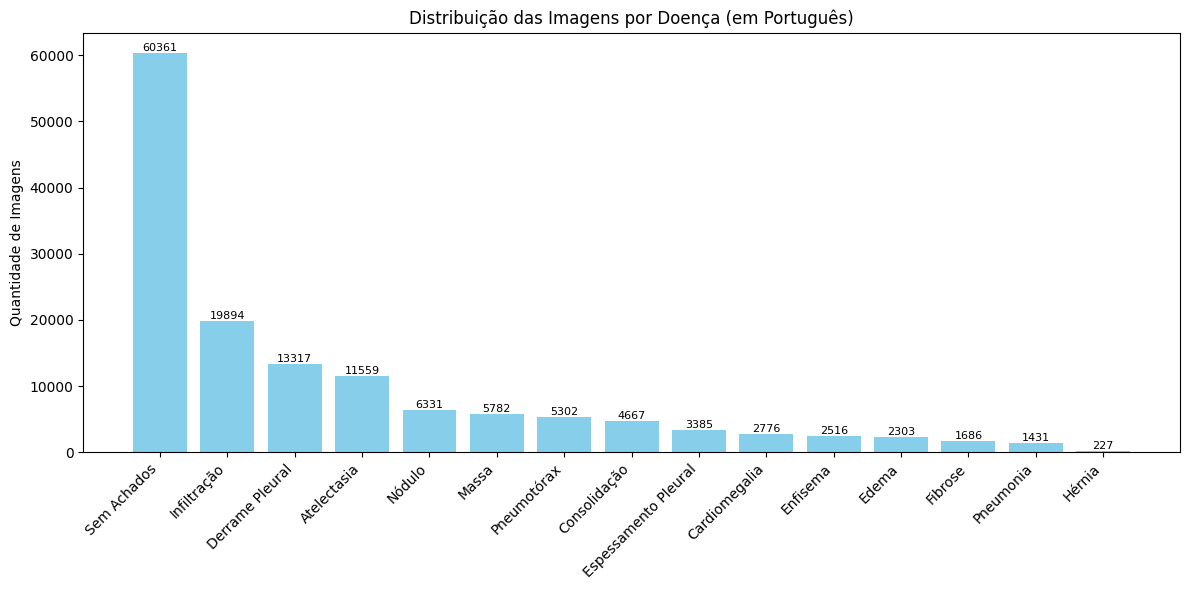

In [1]:
import os
import matplotlib.pyplot as plt
from collections import Counter

# Dicionário de tradução das doenças para português
traducao_doencas = {
    "No Finding": "Sem Achados",
    "Infiltration": "Infiltração",
    "Atelectasis": "Atelectasia",
    "Effusion": "Derrame Pleural",
    "Consolidation": "Consolidação",
    "Nodule": "Nódulo",
    "Mass": "Massa",
    "Cardiomegaly": "Cardiomegalia",
    "Pneumothorax": "Pneumotórax",
    "Edema": "Edema",
    "Emphysema": "Enfisema",
    "Pleural_Thickening": "Espessamento Pleural",
    "Fibrosis": "Fibrose",
    "Pneumonia": "Pneumonia",
    "Hernia": "Hérnia"
}

pasta_saida = "dataset"
contagem = Counter()

# Conta quantas imagens existem por pasta (doença)
for doenca in os.listdir(pasta_saida):
    caminho_doenca = os.path.join(pasta_saida, doenca)
    if os.path.isdir(caminho_doenca):
        contagem[doenca] = len(os.listdir(caminho_doenca))

# Ordena da maior para a menor quantidade
contagem_ordenada = sorted(contagem.items(), key=lambda x: x[1], reverse=True)

# Traduz os nomes para português e prepara dados para o gráfico
labels = [traducao_doencas.get(doenca, doenca) for doenca, _ in contagem_ordenada]
quantidades = [qtd for _, qtd in contagem_ordenada]

# Gráfico de colunas
plt.figure(figsize=(12, 6))
bars = plt.bar(labels, quantidades, color='skyblue')
plt.xticks(rotation=45, ha='right')
plt.ylabel("Quantidade de Imagens")
plt.title("Distribuição das Imagens por Doença (em Português)")

# Adiciona os valores nas barras
for bar, qtd in zip(bars, quantidades):
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height(), str(qtd),
             ha='center', va='bottom', fontsize=8)

plt.tight_layout()
plt.savefig("distribuicao_quantidade_doencas_colunas.png")
plt.show()

### Oversampling no NIH Chest X-ray Dataset

 > Carregando e analisando os dados

In [2]:
import pandas as pd
from collections import Counter

df = pd.read_csv('Data_Entry_2017.csv')
df['Finding Labels'] = df['Finding Labels'].fillna('').astype(str)

# Divide os rótulos por pipe (|)
all_labels = df['Finding Labels'].apply(lambda x: x.split('|'))
flattened_labels = [label for sublist in all_labels for label in sublist]

# Frequência de cada rótulo
label_counts = Counter(flattened_labels)
print("Distribuição de classes:")
for label, count in label_counts.items():
    print(f"{label}: {count}")


Distribuição de classes:
Cardiomegaly: 2776
Emphysema: 2516
Effusion: 13317
No Finding: 60361
Hernia: 227
Infiltration: 19894
Mass: 5782
Nodule: 6331
Atelectasis: 11559
Pneumothorax: 5302
Pleural_Thickening: 3385
Pneumonia: 1431
Fibrosis: 1686
Edema: 2303
Consolidation: 4667


> Convertendo para estrutura multi-label binária

Foi utilizado o MultiLabelBinarizer para transformar os rótulos em vetores binários (0 ou 1).

In [3]:
from sklearn.preprocessing import MultiLabelBinarizer

mlb = MultiLabelBinarizer()
df['Finding Labels'] = df['Finding Labels'].apply(lambda x: x.split('|'))
labels_bin = mlb.fit_transform(df['Finding Labels'])

# Agora labels_bin é uma matriz de shape (n_amostras, n_classes)
print("Shape binarizado:", labels_bin.shape)
print("Classes:", mlb.classes_)


Shape binarizado: (112120, 15)
Classes: ['Atelectasis' 'Cardiomegaly' 'Consolidation' 'Edema' 'Effusion'
 'Emphysema' 'Fibrosis' 'Hernia' 'Infiltration' 'Mass' 'No Finding'
 'Nodule' 'Pleural_Thickening' 'Pneumonia' 'Pneumothorax']


> Aplicando Oversampling (baseado em replicação)

Como o dataset é de imagens, usamos oversampling por replicação de amostras. Exemplo: para cada classe minoritária, replicamos imagens até igualar a classe majoritária.


In [4]:
import numpy as np

# Combina os dados
df['encoded_labels'] = list(labels_bin)

# Define a quantidade alvo para cada classe (máximo entre todas)
max_per_class = max(label_counts.values())

# Dicionário para armazenar novas amostras
augmented_rows = []

# Oversampling
for idx, row in df.iterrows():
    labels = row['Finding Labels']
    enc_labels = row['encoded_labels']

    # Verifica quantas vezes essa imagem precisa ser replicada
    max_reps = max([max_per_class // label_counts[label] for label in labels])

    for _ in range(max_reps):
        augmented_rows.append(row)

# Cria novo DataFrame com oversampling aplicado
df_balancedOver = pd.DataFrame(augmented_rows)

print(f"\nTotal de amostras após oversampling: {len(df_balancedOver)}")



Total de amostras após oversampling: 703760


> Validando a nova distribuição do Oversampling

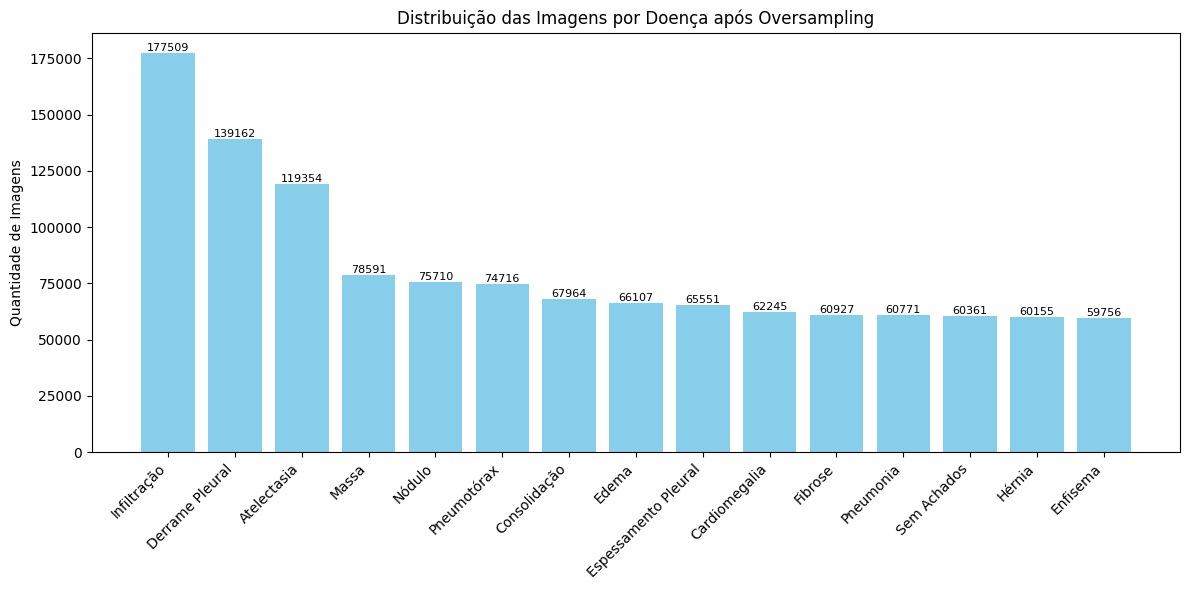

In [7]:
import matplotlib.pyplot as plt
from collections import Counter

# Dicionário de tradução das doenças para português
traducao_doencas = {
    "No Finding": "Sem Achados",
    "Infiltration": "Infiltração",
    "Atelectasis": "Atelectasia",
    "Effusion": "Derrame Pleural",
    "Consolidation": "Consolidação",
    "Nodule": "Nódulo",
    "Mass": "Massa",
    "Cardiomegaly": "Cardiomegalia",
    "Pneumothorax": "Pneumotórax",
    "Edema": "Edema",
    "Emphysema": "Enfisema",
    "Pleural_Thickening": "Espessamento Pleural",
    "Fibrosis": "Fibrose",
    "Pneumonia": "Pneumonia",
    "Hernia": "Hérnia"
}

# Contagem dos rótulos após oversampling (do DataFrame df_balancedOVER)
new_counts = Counter([label for labels in df_balancedOver['Finding Labels'] for label in labels])
contagem_ordenada = sorted(new_counts.items(), key=lambda x: x[1], reverse=True)

# Traduz os nomes para português
labels = [traducao_doencas.get(doenca, doenca) for doenca, _ in contagem_ordenada]
quantidades = [qtd for _, qtd in contagem_ordenada]

# Gráfico de colunas
plt.figure(figsize=(12, 6))
bars = plt.bar(labels, quantidades, color='skyblue')
plt.xticks(rotation=45, ha='right')
plt.ylabel("Quantidade de Imagens")
plt.title("Distribuição das Imagens por Doença após Oversampling")

# Adiciona os valores nas barras
for bar, qtd in zip(bars, quantidades):
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height(), str(qtd),
             ha='center', va='bottom', fontsize=8)

plt.tight_layout()
plt.savefig("distribuicao_oversampling_doencas.png")
plt.show()


## Após esse trabalho:
> Separando Train/Test

In [9]:
from sklearn.model_selection import train_test_split

train_df, test_df = train_test_split(df_balancedOver, test_size=0.2, random_state=42, shuffle=True)

print(f"Tamanho do treino: {len(train_df)}")
print(f"Tamanho do teste: {len(test_df)}")


Tamanho do treino: 563008
Tamanho do teste: 140752


> Carregar imagens + labels para o treino do modelo:

In [8]:
from torchvision import transforms
from PIL import Image
from torch.utils.data import Dataset

class ChestXRayDataset(Dataset):
    def __init__(self, dataframe, transform=None):
        self.df = dataframe.reset_index(drop=True)
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.loc[idx]
        image_path = row['image_path']  # Você precisa ter isso carregado
        labels = row['encoded_labels']

        image = Image.open(image_path).convert('RGB')
        if self.transform:
            image = self.transform(image)

        return image, np.array(labels).astype(float)


### Undersampling no NIH Chest X-ray Dataset

> Carregando e preparando os dados

In [1]:
import pandas as pd
from collections import Counter

df = pd.read_csv('Data_Entry_2017.csv')
df['Finding Labels'] = df['Finding Labels'].fillna('').astype(str)
df['Finding Labels'] = df['Finding Labels'].apply(lambda x: x.split('|'))

# Frequência de classes
all_labels = [label for sublist in df['Finding Labels'] for label in sublist]
label_counts = Counter(all_labels)

print("Distribuição de classes original:")
for label, count in label_counts.items():
    print(f"{label}: {count}")

min_per_class = min(label_counts.values())
print(f"\n➡️ Menor classe tem: {min_per_class} amostras")


Distribuição de classes original:
Cardiomegaly: 2776
Emphysema: 2516
Effusion: 13317
No Finding: 60361
Hernia: 227
Infiltration: 19894
Mass: 5782
Nodule: 6331
Atelectasis: 11559
Pneumothorax: 5302
Pleural_Thickening: 3385
Pneumonia: 1431
Fibrosis: 1686
Edema: 2303
Consolidation: 4667

➡️ Menor classe tem: 227 amostras


### Mapeando quais imagens pertencem a quais rótulos

> mapa imagem → rótulos e também rótulo → lista de imagens

In [2]:
from collections import defaultdict

# rótulo → lista de índices da imagem
label_to_indices = defaultdict(list)
for idx, labels in df['Finding Labels'].items():
    for label in labels:
        label_to_indices[label].append(idx)


### Selecionando amostras balanceadas por rótulo

> Como há amostras com multi-labels, o processo deve:

1. Ir selecionando imagens únicas por rótulo.
2. Parar quando atingirmos min_per_class imagens por classe.

In [3]:
selected_indices = set()
label_counter = defaultdict(int)

# Iteramos várias vezes para coletar até min_per_class por rótulo
for label in label_to_indices:
    indices = label_to_indices[label]
    added = 0
    for idx in indices:
        if label_counter[label] >= min_per_class:
            break
        if idx not in selected_indices:
            selected_indices.add(idx)
            for l in df.loc[idx, 'Finding Labels']:
                label_counter[l] += 1
            added += 1


### Criando novo dataframe balanceado - Under

In [4]:
df_balancedUnder = df.loc[list(selected_indices)].reset_index(drop=True)

# Verificar nova distribuição
from collections import Counter

balanced_labels = [label for labels in df_balancedUnder['Finding Labels'] for label in labels]
new_counts = Counter(balanced_labels)

print("\nDistribuição após undersampling:")
for label, count in new_counts.items():
    print(f"{label}: {count}")



Distribuição após undersampling:
Cardiomegaly: 249
Emphysema: 232
Effusion: 418
No Finding: 227
Hernia: 227
Infiltration: 515
Nodule: 250
Pleural_Thickening: 241
Atelectasis: 345
Pneumothorax: 239
Mass: 235
Pneumonia: 227
Fibrosis: 227
Edema: 227
Consolidation: 227


### Valindando o processo de Undersampling

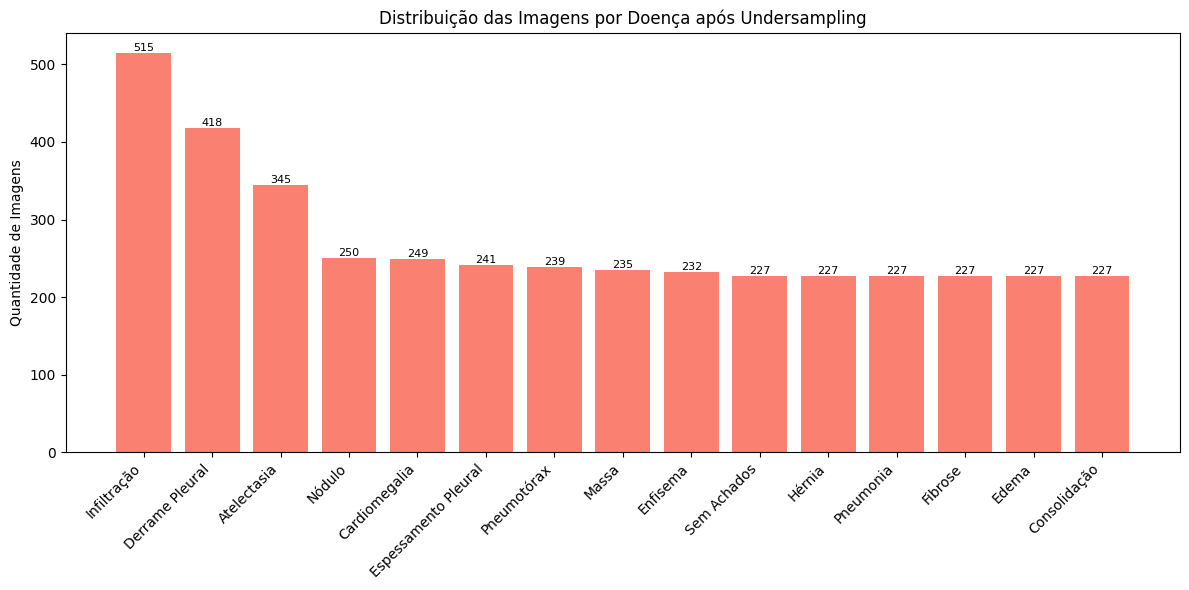

In [6]:
# Usa os dados já extraídos de new_counts
import matplotlib.pyplot as plt

traducao_doencas = {
    "No Finding": "Sem Achados",
    "Infiltration": "Infiltração",
    "Atelectasis": "Atelectasia",
    "Effusion": "Derrame Pleural",
    "Consolidation": "Consolidação",
    "Nodule": "Nódulo",
    "Mass": "Massa",
    "Cardiomegaly": "Cardiomegalia",
    "Pneumothorax": "Pneumotórax",
    "Edema": "Edema",
    "Emphysema": "Enfisema",
    "Pleural_Thickening": "Espessamento Pleural",
    "Fibrosis": "Fibrose",
    "Pneumonia": "Pneumonia",
    "Hernia": "Hérnia"
}

contagem_ordenada = sorted(new_counts.items(), key=lambda x: x[1], reverse=True)
labels = [traducao_doencas.get(doenca, doenca) for doenca, _ in contagem_ordenada]
quantidades = [qtd for _, qtd in contagem_ordenada]

plt.figure(figsize=(12, 6))
bars = plt.bar(labels, quantidades, color='salmon')
plt.xticks(rotation=45, ha='right')
plt.ylabel("Quantidade de Imagens")
plt.title("Distribuição das Imagens por Doença após Undersampling")
for bar, qtd in zip(bars, quantidades):
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height(), str(qtd),
             ha='center', va='bottom', fontsize=8)
plt.tight_layout()
plt.savefig("distribuicao_undersampling_doencas.png")
plt.show()


## Gerando um novo Dataset balanceado - Undersampling

In [5]:
import os
import shutil
import pandas as pd
from tqdm import tqdm
from collections import defaultdict, Counter
from sklearn.model_selection import train_test_split

# -------------------- CONFIG --------------------
csv_path = 'Data_Entry_2017.csv'
base_image_dir = 'archive'
output_base_dir = 'yolo_classification_dataset_undersampled'
train_dir = os.path.join(output_base_dir, 'train')
val_dir = os.path.join(output_base_dir, 'val')
# ------------------------------------------------

# 1. Carrega o CSV
print("📄 Lendo arquivo CSV...")
df = pd.read_csv(csv_path)
df['Finding Labels'] = df['Finding Labels'].fillna('').astype(str)
df['Finding Labels'] = df['Finding Labels'].apply(lambda x: x.split('|'))

# 2. Mapeia imagem → rótulo e rótulo → imagem
print("🧠 Mapeando imagens e rótulos...")
label_to_indices = defaultdict(list)
for idx, labels in df['Finding Labels'].items():
    for label in labels:
        label_to_indices[label].append(idx)

# Frequência de cada classe
label_counts = Counter([label for sublist in df['Finding Labels'] for label in sublist])
min_per_class = min(label_counts.values())

print("\n📊 Distribuição original:")
for label, count in label_counts.items():
    print(f"{label}: {count}")
print(f"\n✂️ Limitando para {min_per_class} amostras por classe (undersampling)\n")

# 3. Seleciona imagens para balancear com undersampling
selected_indices = set()
label_counter = defaultdict(int)

for label in tqdm(label_to_indices, desc="Selecionando amostras"):
    indices = label_to_indices[label]
    added = 0
    for idx in indices:
        if label_counter[label] >= min_per_class:
            break
        if idx not in selected_indices:
            selected_indices.add(idx)
            for l in df.loc[idx, 'Finding Labels']:
                label_counter[l] += 1
            added += 1

df_balanced = df.loc[list(selected_indices)].reset_index(drop=True)

# 4. Localiza os caminhos das imagens
print("\n🔍 Localizando caminhos das imagens...")
image_dirs = [os.path.join(base_image_dir, f'images_{str(i).zfill(3)}', 'images') for i in range(1, 13)]

def find_image_path(filename):
    for image_dir in image_dirs:
        path = os.path.join(image_dir, filename)
        if os.path.exists(path):
            return path
    return None

df_balanced['image_path'] = tqdm(df_balanced['Image Index'].apply(find_image_path), total=len(df_balanced), desc="Localizando arquivos")
df_balanced = df_balanced[df_balanced['image_path'].notnull()].reset_index(drop=True)

# 5. Verifica nova distribuição
new_counts = Counter([label for labels in df_balanced['Finding Labels'] for label in labels])
print("\n📊 Distribuição após undersampling:")
for label, count in new_counts.items():
    print(f"{label}: {count}")

# 6. Divide treino e validação
train_df, val_df = train_test_split(df_balanced, test_size=0.2, random_state=42)
print(f"\n📁 Divisão:")
print(f"  ➤ Treino: {len(train_df)} imagens")
print(f"  ➤ Validação: {len(val_df)} imagens")

# 7. Função para salvar imagens organizadas por rótulo
def save_images(df_split, target_dir):
    label_set = set()
    for idx, row in tqdm(df_split.iterrows(), total=len(df_split), desc=f"Copiando para {target_dir}"):
        image_path = row['image_path']
        labels = row['Finding Labels']

        for label in labels:
            label_set.add(label)
            label_dir = os.path.join(target_dir, label)
            os.makedirs(label_dir, exist_ok=True)
            dest_path = os.path.join(label_dir, os.path.basename(image_path))
            if not os.path.exists(dest_path):
                shutil.copy2(image_path, dest_path)
    return label_set

# 8. Copia imagens para pastas finais
print("\n💾 Salvando imagens de treino...")
train_classes = save_images(train_df, train_dir)

print("\n💾 Salvando imagens de validação...")
val_classes = save_images(val_df, val_dir)

# 9. Finalização
print("\n✅ UNDERSAMPLING finalizado!")
print("📂 Classes salvas no treino:", sorted(train_classes))
print("📂 Classes salvas na validação:", sorted(val_classes))
print(f"\n🚀 Dataset pronto para uso com YOLOv8 em: {output_base_dir}")


📄 Lendo arquivo CSV...
🧠 Mapeando imagens e rótulos...

📊 Distribuição original:
Cardiomegaly: 2776
Emphysema: 2516
Effusion: 13317
No Finding: 60361
Hernia: 227
Infiltration: 19894
Mass: 5782
Nodule: 6331
Atelectasis: 11559
Pneumothorax: 5302
Pleural_Thickening: 3385
Pneumonia: 1431
Fibrosis: 1686
Edema: 2303
Consolidation: 4667

✂️ Limitando para 227 amostras por classe (undersampling)



Selecionando amostras: 100%|██████████| 15/15 [00:00<00:00, 319.98it/s]


🔍 Localizando caminhos das imagens...



Localizando arquivos: 100%|██████████| 2425/2425 [00:00<?, ?it/s]



📊 Distribuição após undersampling:
Cardiomegaly: 249
Emphysema: 232
Effusion: 418
No Finding: 227
Hernia: 227
Infiltration: 515
Nodule: 250
Pleural_Thickening: 241
Atelectasis: 345
Pneumothorax: 239
Mass: 235
Pneumonia: 227
Fibrosis: 227
Edema: 227
Consolidation: 227

📁 Divisão:
  ➤ Treino: 1940 imagens
  ➤ Validação: 485 imagens

💾 Salvando imagens de treino...


Copiando para yolo_classification_dataset_undersampled\train: 100%|██████████| 1940/1940 [00:14<00:00, 134.14it/s]



💾 Salvando imagens de validação...


Copiando para yolo_classification_dataset_undersampled\val: 100%|██████████| 485/485 [00:03<00:00, 131.97it/s]


✅ UNDERSAMPLING finalizado!
📂 Classes salvas no treino: ['Atelectasis', 'Cardiomegaly', 'Consolidation', 'Edema', 'Effusion', 'Emphysema', 'Fibrosis', 'Hernia', 'Infiltration', 'Mass', 'No Finding', 'Nodule', 'Pleural_Thickening', 'Pneumonia', 'Pneumothorax']
📂 Classes salvas na validação: ['Atelectasis', 'Cardiomegaly', 'Consolidation', 'Edema', 'Effusion', 'Emphysema', 'Fibrosis', 'Hernia', 'Infiltration', 'Mass', 'No Finding', 'Nodule', 'Pleural_Thickening', 'Pneumonia', 'Pneumothorax']

🚀 Dataset pronto para uso com YOLOv8 em: yolo_classification_dataset_undersampled


### Organizando OS DADOS PARA YOLOv8 (Oversampling - Classificação)
>Formato exigido pela v8 do YOLO:

```
dataset/
├── train/
│   ├── Atelectasis/
│   │   ├── img1.png
│   │   ├── ...
│   ├── Pneumonia/
│   ├── No Finding/
│   └── ...
├── val/
│   ├── Atelectasis/
│   └── ...
```

## Gerando um novo Dataset balanceado - Oversampling

In [ ]:
import os
import shutil
import pandas as pd
from sklearn.model_selection import train_test_split
from collections import Counter
from tqdm import tqdm

# Caminhos
csv_path = 'Data_Entry_2017.csv'
base_image_dir = 'archive'
output_base_dir = 'yolo_classification_dataset'
train_dir = os.path.join(output_base_dir, 'train')
val_dir = os.path.join(output_base_dir, 'val')

# Lê CSV
print("📄 Lendo CSV...")
df = pd.read_csv(csv_path)
df['Finding Labels'] = df['Finding Labels'].fillna('').astype(str)
df['Finding Labels'] = df['Finding Labels'].apply(lambda x: x.split('|'))

# Caminhos das imagens
image_dirs = [os.path.join(base_image_dir, f'images_{str(i).zfill(3)}', 'images') for i in range(1, 13)]

def find_image_path(filename):
    for image_dir in image_dirs:
        full_path = os.path.join(image_dir, filename)
        if os.path.exists(full_path):
            return full_path
    return None

print("🔎 Buscando caminhos das imagens...")
df['image_path'] = tqdm(df['Image Index'].apply(find_image_path), total=len(df), desc="Localizando imagens")

# Filtra imagens encontradas
df = df[df['image_path'].notnull()].reset_index(drop=True)
print(f"✅ Total de imagens encontradas: {len(df)}")

# Frequência original
label_counts = Counter([label for labels in df['Finding Labels'] for label in labels])
print("\n📊 Distribuição original das classes:")
for label, count in label_counts.items():
    print(f"{label}: {count}")

max_per_class = max(label_counts.values())

# Oversampling
print("\n🔁 Aplicando oversampling...")
augmented_rows = []
for idx, row in tqdm(df.iterrows(), total=len(df), desc="Gerando dataset balanceado"):
    labels = row['Finding Labels']
    reps = max([max_per_class // label_counts[label] for label in labels])
    for _ in range(reps):
        augmented_rows.append(row)

df_balancedOver = pd.DataFrame(augmented_rows).reset_index(drop=True)
print(f"📈 Total após oversampling: {len(df_balancedOver)}")

# Split treino/val
train_df, val_df = train_test_split(df_balancedOver, test_size=0.2, random_state=42)
print(f"\n🧪 Divisão:")
print(f"  ➤ Treino: {len(train_df)} amostras")
print(f"  ➤ Validação: {len(val_df)} amostras")

# Função para salvar imagens
def save_images(df_split, target_dir):
    label_set = set()
    for idx, row in tqdm(df_split.iterrows(), total=len(df_split), desc=f"Copiando para {target_dir}"):
        image_path = row['image_path']
        labels = row['Finding Labels']
        for label in labels:
            label_set.add(label)
            label_dir = os.path.join(target_dir, label)
            os.makedirs(label_dir, exist_ok=True)
            dest_path = os.path.join(label_dir, os.path.basename(image_path))
            if not os.path.exists(dest_path):
                shutil.copy2(image_path, dest_path)
    return label_set

# Salvar imagens
print("\n💾 Salvando imagens de treino...")
train_classes = save_images(train_df, train_dir)

print("\n💾 Salvando imagens de validação...")
val_classes = save_images(val_df, val_dir)

print("\n📁 Classes presentes no conjunto de treino:", sorted(train_classes))
print("📁 Classes presentes no conjunto de validação:", sorted(val_classes))

print("\n✅ Dataset YOLOv8 (classificação) pronto para uso em:", output_base_dir)


📄 Lendo CSV...
🔎 Buscando caminhos das imagens...
